# Osnovni računi svojstveni Riemannovim prostorima
Klasa Riemann_tools računa sljedeće:
1. Inverz metrike s provjerom dimenzionalnosti - za prostore nepunog ranga daje nan matricu
2. metric_Γ2 računa Christoffelove simbole 2. vrste uz dane simbole 1. vrste i inverz metrike po formuli $\Gamma^\mu_{\alpha\beta}=g^{\mu\nu}\Gamma_{\alpha\beta|\nu}$
3. metric_eigenproblem računa svojstvene vrijednosti i vektore metrike u slučajevima punog i nepunog ranga metrike
4. metric_eigenvalues, metric_eigenvalue, metric_eigenvector raspakiravaju metric_eigenproblem
5. metric_determinant računa determinantu metrike
6. metric_signature računa signaturu metrike odnosno $\sum_i\mathrm{sign}\lambda_i$

Klasa embedded_manifold nasljeđuje Riemann_tools u slučajevima ulaganja mnogostrukosti $(\mathcal{N},g_\mathcal{N})$ u mnogostrukost $\mathcal{M}$ difeomorfizmom $\phi:\mathcal{M}\rightarrow\mathcal{N}$. Klasa služi za izračun pull-back operacije metrike na mnogostrukosti $N$, $g_\mathcal{M}=\phi^*g_\mathcal{N}$ u slučaju kada ja $\mathcal{N}$ snabdjevena euklidskom metrikom. Klasa sadrži sljedeće metode
1. embedded_metric Proračun ulaganja metrike pomoću jakobijana $J_\nu=\partial_\nu\phi$: $g_\mathcal{M}=\sum_i\partial_\mu\phi^i\partial_\nu\phi^i\mathrm{d}x^\mu\mathrm{d}x^\nu$
2. embedded_Γ1 proračun Christoffelovog simbola prve vrste
3. embedded_Γ2 proračun Christoffelovog simbola druge vrste


In [2]:
import autograd as au
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
class Riemann_tools:
    def __init__(self):
        pass
    def metric_inverse(self, g):
        try:
            ginv = np.linalg.inv(g)
        except:
            ginv = np.empty(g.shape)
            ginv.fill(np.nan)
        return ginv
    def metric_Γ2(self,g, Γ1):
        return np.einsum('ij,jab->iab',self.metric_inverse(g),Γ1)
    def metric_eigenproblem(self,g):
        try:
            epr = np.linalg.eigh(g)
        except:
            epr = []
            v = np.empty(g.shape[0])
            λ = np.empty(g.shape)
            v.fill(np.nan)
            λ.fill(np.nan)
            epr=[v,λ]
        return epr
    def metric_eigenvalues(self, g):
        return self.metric_eigenproblem(g)[0]
    def metric_eigenvalue(self, g,k=0)->"kth eigenvalue":
        return self.metric_eigenproblem(g)[0][k]
    def metric_eigenvector(self, g,k=0)->"kth eigenvalue":
        return self.metric_eigenproblem(g)[1][:,k]
    def metric_determinant(self,g)->"determinant of g":
        return np.linalg.det(g)
    def metric_signature(self,g)->"Metric signature":
        return np.sum(np.sign(self.metric_eigenvalues(g)))
class embedded_manifold(Riemann_tools):
    def __init__(self):
         Riemann_tools.__init__(self)
    def embedded_metric(self,J):
        return np.einsum('im,in',J,J)
    def embedded_Γ1(self,J, H):
        return np.einsum('im,iab->mab',J,H)
    def embedded_Γ2(self,J, H,g):
        return self.metric_Γ2(g,self.embedded_Γ1(J,H))

# Proračun Fisherove informacijske metrike

## Proračuni
Klasa dif_FIM računa sljedeće
1. Pri pozivu, konstruktor upisuje podatke ($t_i,y_i,\sigma_i$) u objekt te za dani model daje proračun jakobijana i hesijana pomoću paketa autograd
2. _r daje proračun reziduala
3. χ2 računa $\chi^2$ vrijednost za dane parametre $\theta$
4. g računa FIM
5. eigval, eigvector, det g, signature, ginv, Γ1,  Γ2 pozivaju odgovarajuće metode iz embedded_manifold za određeni $\theta$
6. Tretiranje metrike nepunog ranga: metode find_offending_index, delete_offending_index reduciraju metrički tenzor ako dolazimo do ruba mnogostrukosti
7. Rješavanje geodezijske jednadžbe:
    - Zapis početnih uvjeta za geodezijsku jednadžbu find_MBAM_IC
    - Zapis sustava ODE za geodezijsku jednadžbu MBAM_RHS
    - Poziv odeint-a run_MBAM
8. statistics daje vrijednosti poput jakobijana, hesijana i zakrivljenosti za dani $\theta$
9. Klasa solution_class je korištena za lakši zapis podataka za plotanje
10. bar_plot daje prikaz svojstvenih vektora

In [5]:
class solution_class:
    "pojednostavljeni upis rješenja ODJ"
    def __init__(self,**kwargs):
        for k,v in kwargs.items():
            if v is not None:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] = []
    def update(self,**kwargs):
        for k,v in kwargs.items():
            if v is not None:
                self.__dict__[k] = self.__dict__[k]+[v]
            else:
                self.__dict__[k] = self.__dict__[k]+[]
    def array(self):
        for k, v in self.__dict__.items():
            self.__dict__[k] = np.array(v)
    def strip(self):
        for k, v in self.__dict__.items():
            self.__dict__[k] = v[0]
    def wrap(self):
        for k, v in self.__dict__.items():
            self.__dict__[k] = [v]
class diff_FIM(embedded_manifold):
    def __init__(self,t:"x-axis measurements", y:"measurements",σ:"errors",model:"model function"):
        self.t  = t
        self.y  = y
        self.f  = model
        self.σ  = σ
        self.J  = au.jacobian(lambda θ:(y-model(t,θ))/σ)
        self.H  = au.hessian(lambda θ:(y-model(t,θ))/σ)
        embedded_manifold.__init__(self)
    def _r(self, θ:"Model parameters")->"Residuals":
        return (self.y-self.f(self.t,θ))/self.σ
    def χ2(self, θ:"Model parameters")->"χ^2 value":
        return np.sum((self.y-self.f(self.t,θ))**2/self.σ**2)
    def g(self, θ:"Model parameters")->"FIM for parameters θ":
        return self.embedded_metric(self.J(θ))
    def eigval(self, θ:"Model parameters",k=0)->"kth eigenvalue for parameters θ":
        return self.metric_eigenvalue(self.g(θ),k)
    def eigvector(self, θ:"Model parameters",k=0)->"kth eigenvalue for parameters θ":
        return self.metric_eigenvector(self.g(θ),k)
    def detg(self,θ:"Model parameters")->"determinant of FIM":
        return self.metric_determinant(self.g(θ))
    def signature(self,θ:"Model parameters")->"Metric signature":
        return self.metric_signature(self.g(θ))
    def ginv(self,θ:"Model parameters")->"Metric inverse":
        return self.metric_inverse(self.g(θ))
    def Γ1(self,θ:"Model parameters")->"Christoffel symbols of the first kind":
        return self.embedded_Γ1(self.J(θ),self.H(θ))
    def Γ2(self,θ:"Model parameters")->"Christoffel symbols of the second kind":
        return self.embedded_Γ2(self.J(θ), self.H(θ),self.g(θ))
    
    def delete_offending_index(self,tensor:"tensor of any rank",i:"which dimension to remove")->"minor of the tensor":
        Naxis = np.size(tensor.shape)
        NewT  = tensor
        for j in range(Naxis):
            NewT = np.delete(NewT,i,axis=j)
        return NewT
    def find_offending_index(self,g:"Metric tensor")->"Finds minor of FIM without which the FIM has a full rank":
        N      = g.shape[0]
        cut    = np.array([np.linalg.matrix_rank(self.delete_offending_index(g,i)) 
                               for i in range(N)])==(N-1)
        if np.sum(cut)==0:
            raise Warning('Nothing found by removing 1 axis')
        return np.argmax(cut)
    def find_MBAM_IC(self,θ:"Model parameters",k:"Index of the eigendirection"=0)->"Produces initial conditions for the geodesic equation":
        g = self.g(θ)
        N = g.shape[0]
        if np.linalg.matrix_rank(g)==N:
            λ,v    = self.metric_eigenproblem(g)
            V = v[:,k]
            θ2   = np.einsum('i,j,ij',θ, θ,g)
            v2   = np.einsum('i,j,ij',V,V,g)  
        elif k<N-1:
            i = self.find_offending_index(g)
            gnew = self.delete_offending_index(g,i)
            θnew = self.delete_offending_index(θ,i)
            λ,v    = np.linalg.eigh(gnew)
            θ2   = np.einsum('i,j,ij',θnew, θnew,gnew)
            v2   = np.einsum('i,j,ij',v[:,k],v[:,k],gnew)
            v = v[:,k]
            V = np.append(v[:i],[0])
            V = np.append(V,v[i:])
        else:
            i      = self.find_offending_index(g)
            V      = np.zeros(N)
            V[i]   = 1
            gnew = self.delete_offending_index(g,i)
            θnew = self.delete_offending_index(θ,i)
            λ,v    = self.metric_eigenproblem(gnew)
            θ2   = np.einsum('i,j,ij',θnew, θnew,gnew)
            v2   = np.einsum('i,j,ij',v[:,0],v[:,0],gnew)
        τ = np.sqrt(θ2/v2)
        return np.append(θ, V),τ

    def MBAM_RHS(self,V:"2N dimensional initial conditions vector")->"RHS of the geodesic equation":
        N   = int(np.size(V)/2)
        θ   = V[:N]
        dθ  = V[N:]
        g   = self.g(θ)
        ret = np.array([dθ])
        if np.linalg.matrix_rank(g)==N:
            
            ret = np.append(ret,-np.einsum('a,b,cab->c',dθ,dθ,self.Γ2(θ)))
        else:
            return np.array(2*N*[np.nan])
        
        return ret
    
    def statistics(self,θ):
            y  = self.f(self.t,θ)
            J  = self.J(θ)
            g  = self.g(θ)
            Γ2 = self.Γ2(θ)
            return y, J, g, Γ2
    def run_MBAM(self,θ:"Model parameters",k:"Initial eigendirection"=0,T=None)->"computes the geodesic equation":
        def fun(V,t):
            return self.MBAM_RHS(V)
        V0,τ = self.find_MBAM_IC(θ,k)
        N_parameters=int(np.size(V0)/2)
        if T is None:
            T    = np.linspace(0,10*τ,100)
            constructed_τ = True
        else:
            constructed_τ = False
        sols = solution_class(y=None,J=None, g=None,
                              Γ2=None,τ=None,θ=None, dθ=None,detg=None)
        S = odeint(fun,V0,T)
        i = 0
        while  i < len(T):
                V = S[i]
                
                y, J, g, Γ2=self.statistics(V[:N_parameters])
                sols.update(y=y, J=J, g=g, Γ2=Γ2, τ=T[i],
                            θ=V[:N_parameters],dθ=V[N_parameters:],
                           detg=np.linalg.det(g))
                i+=1
        sols.array()
        if constructed_τ:
            return τ, sols
        else:
            return sols
def bar_plot(ax:"Axis to plot on",*args:"Vectors to plot",
             xlabel='',ylabel='',plabels:"x tick labels"=None,
             labels:"Labels of vectors"=None,colors:"Vector colors"=None,lw=1):
        Nv = len(args)
        bw = .5/Nv
        for i in range(Nv):
            v  = args[i]
            if labels is not None and i<len(labels):
                label = labels[i]
            else:
                label = ""
            if colors is not None and i<len(colors):
                color = colors[i]
            else:
                color = "k"
            Nθ = np.size(v)
            ax.bar(np.arange(Nθ)+bw,np.abs(v),.8/Nv, 
                   color=np.where(v>0,color,"1.0"),
                   edgecolor=color,label=label,lw=1)
            bw+=1/Nv
        ax.set_xticks(np.arange(0.5,Nθ+.5,1))
        ax.set_yscale('log')
        if plabels is not None:
            ax.set_xticklabels(plabels)
        else:
            ax.set_xticklabels([r"$\theta^{"+"%d"%i+"}$" for i in range(Nθ)])
        if labels is not None:
            ax.legend()

# Redukcija modela
Podatke simuliramo pomoću modela
$$
y(t,\theta^0,\theta^1,\theta^2,\theta^3,\theta^4)=\frac{\theta^0+t\theta^1+t^2\theta^2+t^3\theta^3}{1+t\theta^4}.
$$
Kod pronalazi koji od parametara možemo prvi eliminirati, uz najmanje smanjenje informacije.

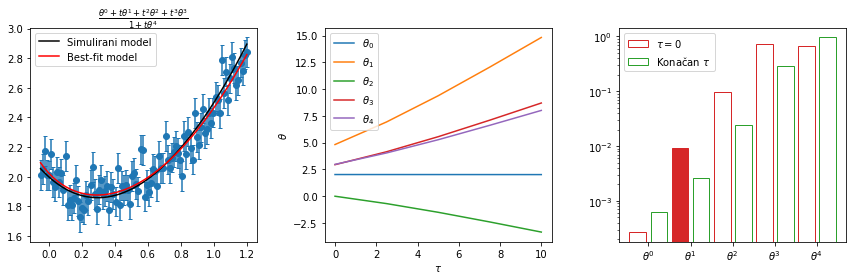

In [105]:
class model(MBAM_plotting):
    def __init__(self,*args,**kwargs):
        MBAM_plotting.__init__(self,self._model,'Fractional/razlomljen',*args,**kwargs)
        self._title = r'$\frac{\theta^0+t\theta^1+t^2\theta^2+t^3\theta^3}{1+t\theta^4}$'
    def _model(self,T,θ):
        x0,x1,x2,x3,x4=θ
        return (x0+x1*T+x2*np.power(T,2)+x3*np.power(T,3))/(1.+x4*np.power(T,1))
    
N_D = 100
σ   = .1
bf  = np.array([2]+4*[1.])
X   = np.linspace(-.05,1.2,N_D)
Y   = np.random.normal(0,σ,N_D)+model._model(model,X,bf)
x   = np.linspace(-.05,1.2)
BF0 = curve_fit(lambda T, x0,x1,x2,x3,x4:(x0+x1*T+x2*np.power(T,2)+x3*np.power(T,3))/(1.+x4*np.power(T,1)),X,Y, bounds=[5*[0],5*[np.inf]])[0]
MPL = model(X,Y,σ*Y/Y,bf,xlim=[-1,1],ylim=[0,2])

MPL.MBAM   = MPL.run_MBAM(BF0,k=0,T=np.linspace(0,10,5))

f,ax = plt.subplots(1,3,figsize=(4*3,4))
ax[0].errorbar(X,Y,yerr=σ,fmt='C0o',capsize=2,zorder=0)
ax[0].plot(x,MPL._model(x,bf),"k",label='Simulirani model')
ax[0].plot(x,MPL._model(x,BF0),"r",label='Best-fit model')
ax[0].set_title(MPL._title)
ax[0].legend()
for i in range(5):
    ax[1].plot(MPL.MBAM.τ,MPL.MBAM.θ[:,i],label=r'$\theta'+'_%d$'%i)
ax[1].legend()
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlabel(r'$\tau$')
bar_plot(ax[2],np.linalg.eigh(MPL.g(MPL.MBAM.θ[0]))[1][0,:],
             np.linalg.eigh(MPL.g(MPL.MBAM.θ[-1]))[1][0,:],colors=['C3','C2'],
             labels=[r"$\tau=0$",r"Konačan $\tau$"])
f.tight_layout()

## Prilagodba reduciranog modela
$$
y(t,\theta^0,\theta^1,\theta^2,\theta^3)=\theta^0+t\theta^1+t^2\theta^2+t^3\theta^3.
$$

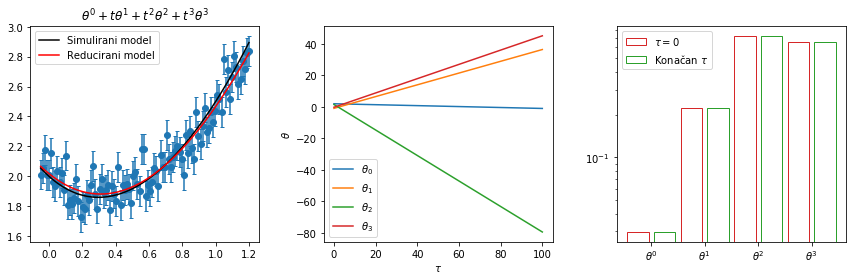

In [107]:
from scipy.optimize import curve_fit
class model_red(MBAM_plotting):
    def __init__(self,*args,**kwargs):
        MBAM_plotting.__init__(self,self._model,'Fractional/razlomljen',*args,**kwargs)
        self._title = r'$\theta^0+t\theta^1+t^2\theta^2+t^3\theta^3$'
    def _model(self,T,θ):
        x0,x1,x2,x3=θ
        return (x0+x1*T+x2*np.power(T,2)+x3*np.power(T,3))

BF1  = curve_fit(lambda T, x0,x1,x2,x3:(x0+x1*T+x2*np.power(T,2)+x3*np.power(T,3)),X,Y, bounds=[4*[-np.inf],4*[np.inf]])[0]
MPL1 = model_red(X,Y,σ*Y/Y,BF1,xlim=[-1,1],ylim=[0,2])
MPL1.MBAM   = MPL1.run_MBAM(BF1,k=0,T=np.linspace(0,100,50))

f,ax = plt.subplots(1,3,figsize=(4*3,4))
ax[0].errorbar(X,Y,yerr=σ,fmt='C0o',capsize=2,zorder=0)
ax[0].plot(x,MPL._model(x,bf),"k",label='Simulirani model')
ax[0].plot(x,MPL1._model(x,BF1),"r",label='Reducirani model')
ax[0].set_title(MPL1._title)
ax[0].legend()
for i in range(4):
    ax[1].plot(MPL1.MBAM.τ,MPL1.MBAM.θ[:,i],label=r'$\theta'+'_%d$'%i)
ax[1].legend()
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlabel(r'$\tau$')
bar_plot(ax[2],np.linalg.eigh(MPL1.g(MPL1.MBAM.θ[0]))[1][0,:],
             np.linalg.eigh(MPL1.g(MPL1.MBAM.θ[-1]))[1][0,:],colors=['C3','C2'],
             labels=[r"$\tau=0$",r"Konačan $\tau$"])
f.tight_layout()

## Prilagodba dvostruko reduciranog modela
$$
y(t,\theta^0,\theta^1,\theta^3)=\theta^0+t\theta^1+t^3\theta^3.
$$

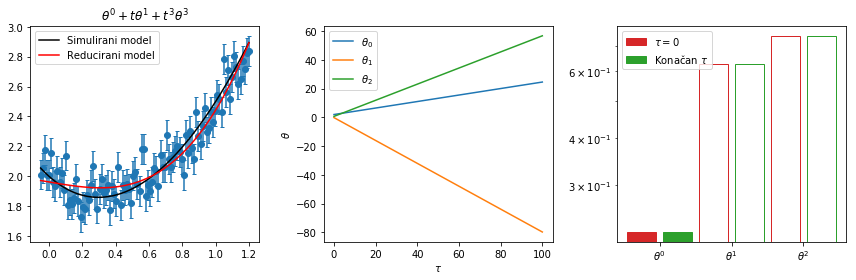

In [108]:
from scipy.optimize import curve_fit
class model_red2(MBAM_plotting):
    def __init__(self,*args,**kwargs):
        MBAM_plotting.__init__(self,self._model,'Fractional/razlomljen',*args,**kwargs)
        self._title = r'$\theta^0+t\theta^1+t^3\theta^3$'
    def _model(self,T,θ):
        x0,x1,x2=θ
        return (x0+x1*T+x2*np.power(T,3))

BF2 = curve_fit(lambda T, x0,x1,x2:(x0+x1*T+x2*np.power(T,3)),X,Y, bounds=[3*[-np.inf],3*[np.inf]])[0]
MPL2 = model_red2(X,Y,σ*Y/Y,BF2,xlim=[-1,1],ylim=[0,2])
MPL2.MBAM   = MPL2.run_MBAM(BF2,k=0,T=np.linspace(0,100,50))

f,ax = plt.subplots(1,3,figsize=(4*3,4))
ax[0].errorbar(X,Y,yerr=σ,fmt='C0o',capsize=2,zorder=0)
ax[0].plot(x,MPL._model(x,bf),"k",label='Simulirani model')
ax[0].plot(x,MPL2._model(x,BF2),"r",label='Reducirani model')
ax[0].set_title(MPL2._title)
ax[0].legend()
for i in range(3):
    ax[1].plot(MPL2.MBAM.τ,MPL2.MBAM.θ[:,i],label=r'$\theta'+'_%d$'%i)
ax[1].legend()
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlabel(r'$\tau$')

bar_plot(ax[2],np.linalg.eigh(MPL2.g(MPL2.MBAM.θ[0]))[1][0,:],
             np.linalg.eigh(MPL2.g(MPL2.MBAM.θ[-1]))[1][0,:],colors=['C3','C2'],
             labels=[r"$\tau=0$",r"Konačan $\tau$"])
f.tight_layout()